## Chapter 11: Principles of Feature Learning

# 11.5 Ensembling methods

As we discussed in detail in Section 11.2, validation data is the data we exclude at random from the training process. The error generated by our trained model on this 'unseen' portion of data, which we call validation error, is the fundamental measurement tool we use to determine an appropriate cross-validated model for our entire dataset. However the random nature of splitting data into training and validation poses a potentially major issue: what if this random splitting creates training and validation portions which are not desirable representatives of the underlying phenomenon that generated them? In other words, in practice certain training-validation splits can result in poorly representative cross-validated models.

Because we *need* cross-validation in order to choose appropriate models in general, and because we can do nothing about the (random) *nature* by which we split our data for cross-validation (what better is there to simulate the 'future' of our phenomeon?), the practical solution is to perform several different training-validation splits, determine an appropriate model on each split, and then *average* the resulting cross-validated models.  

By averaging a set of cross-validated models - also referred to as *ensembling* - we can both 'average out' the malbehavior of poor models while synergizing the 'good parts' of all models involved.  Moreover with *ensembling* we can also combine cross-validated models built from *different universal approximators*.  Indeed this is the most reasonable way of creating a single model built from different types of universal approximators in practice.

Here we will walk through the concept of ensembling for regression, as well as two-class and multi-class classification by exploring an array of simple examples.  However the principles detailed here can be empoyed more widely as well, e.g., for autoencoders.  As we will see, the best way to average / ensemble a set of cross-validated regression models is by taking their *median* and cross-validated classification models by computing the *mode* of their predicted labels.

In [1]:
## This code cell will not be shown in the HTML version of this notebook
# imports from custom library
import sys
sys.path.append('../../')
from mlrefined_libraries import math_optimization_library as optlib
from mlrefined_libraries import nonlinear_superlearn_library as nonlib
from mlrefined_libraries import basics_library 

# demos for this notebook
regress_plotter = nonlib.nonlinear_regression_demos_multiple_panels
classif_plotter = nonlib.nonlinear_classification_visualizer_multiple_panels
static_plotter = optlib.static_plotter.Visualizer()
basic_runner = nonlib.basic_runner
classif_plotter_crossval = nonlib.crossval_classification_visualizer
datapath = '../../mlrefined_datasets/nonlinear_superlearn_datasets/'

# import autograd functionality to bulid function's properly for optimizers
import autograd.numpy as np

# import timer
from datetime import datetime 
import copy
import math

# this is needed to compensate for %matplotlib notebook's tendancy to blow up images when plotted inline
%matplotlib notebook
from matplotlib import rcParams
rcParams['figure.autolayout'] = True

%load_ext autoreload
%autoreload 2

## 11.5.1  Ensembling cross-validated regression models

Here we explore several examples of applying averaging / ensembling to an array of cross-validated regression models.  More often than not the best way to *average cross-validated regression models is by taking their median* (as opposed to their *mean*).    

#### <span style="color:#a50e3e;">Example 1. </span>  Ensembling cross-validated regression models for a simple dataset

In the set of small panels in the left below we show $10$ different training-validation splits of our prototypical regression dataset, where $\frac{4}{5}$ of the data in each instance is used for training (colored light blue) and $\frac{1}{5}$ is used for validation (colored yellow), first introduced in Section 10.2.1.  Plotted with each split of the original data is the corresponding cross-validated model found by trying out the range of complete polynomial models of degree $1$ to $20$.  As we can see while *many* of these cross-validated models perform quite well, several of them (due to the particular training-validation split on which they are based) severly *underfit* or *overfit* the original dataset.  To re-iterate on these splits where we ended up with poorly performing models we 'did everything right' in terms of cross-validation - the poorly performance is completely due to the underlying (random) training-validation split.  By taking an *average* of the $10$ cross-validated models shown below -  many of which perform quite well, but several of which perform poorly either severely underfitting or overfitting the entire datset - we can average-out the poor performance of the handful of bad models.   We show the fit provided by the *median* of the these ten models in *red* in the large right panel, plotted on top of the original dataset.  This *median model* - or *ensembled model* - fits the data quite nicely, and would be a strong predictor of future input.

<IPython.core.display.Javascript object>


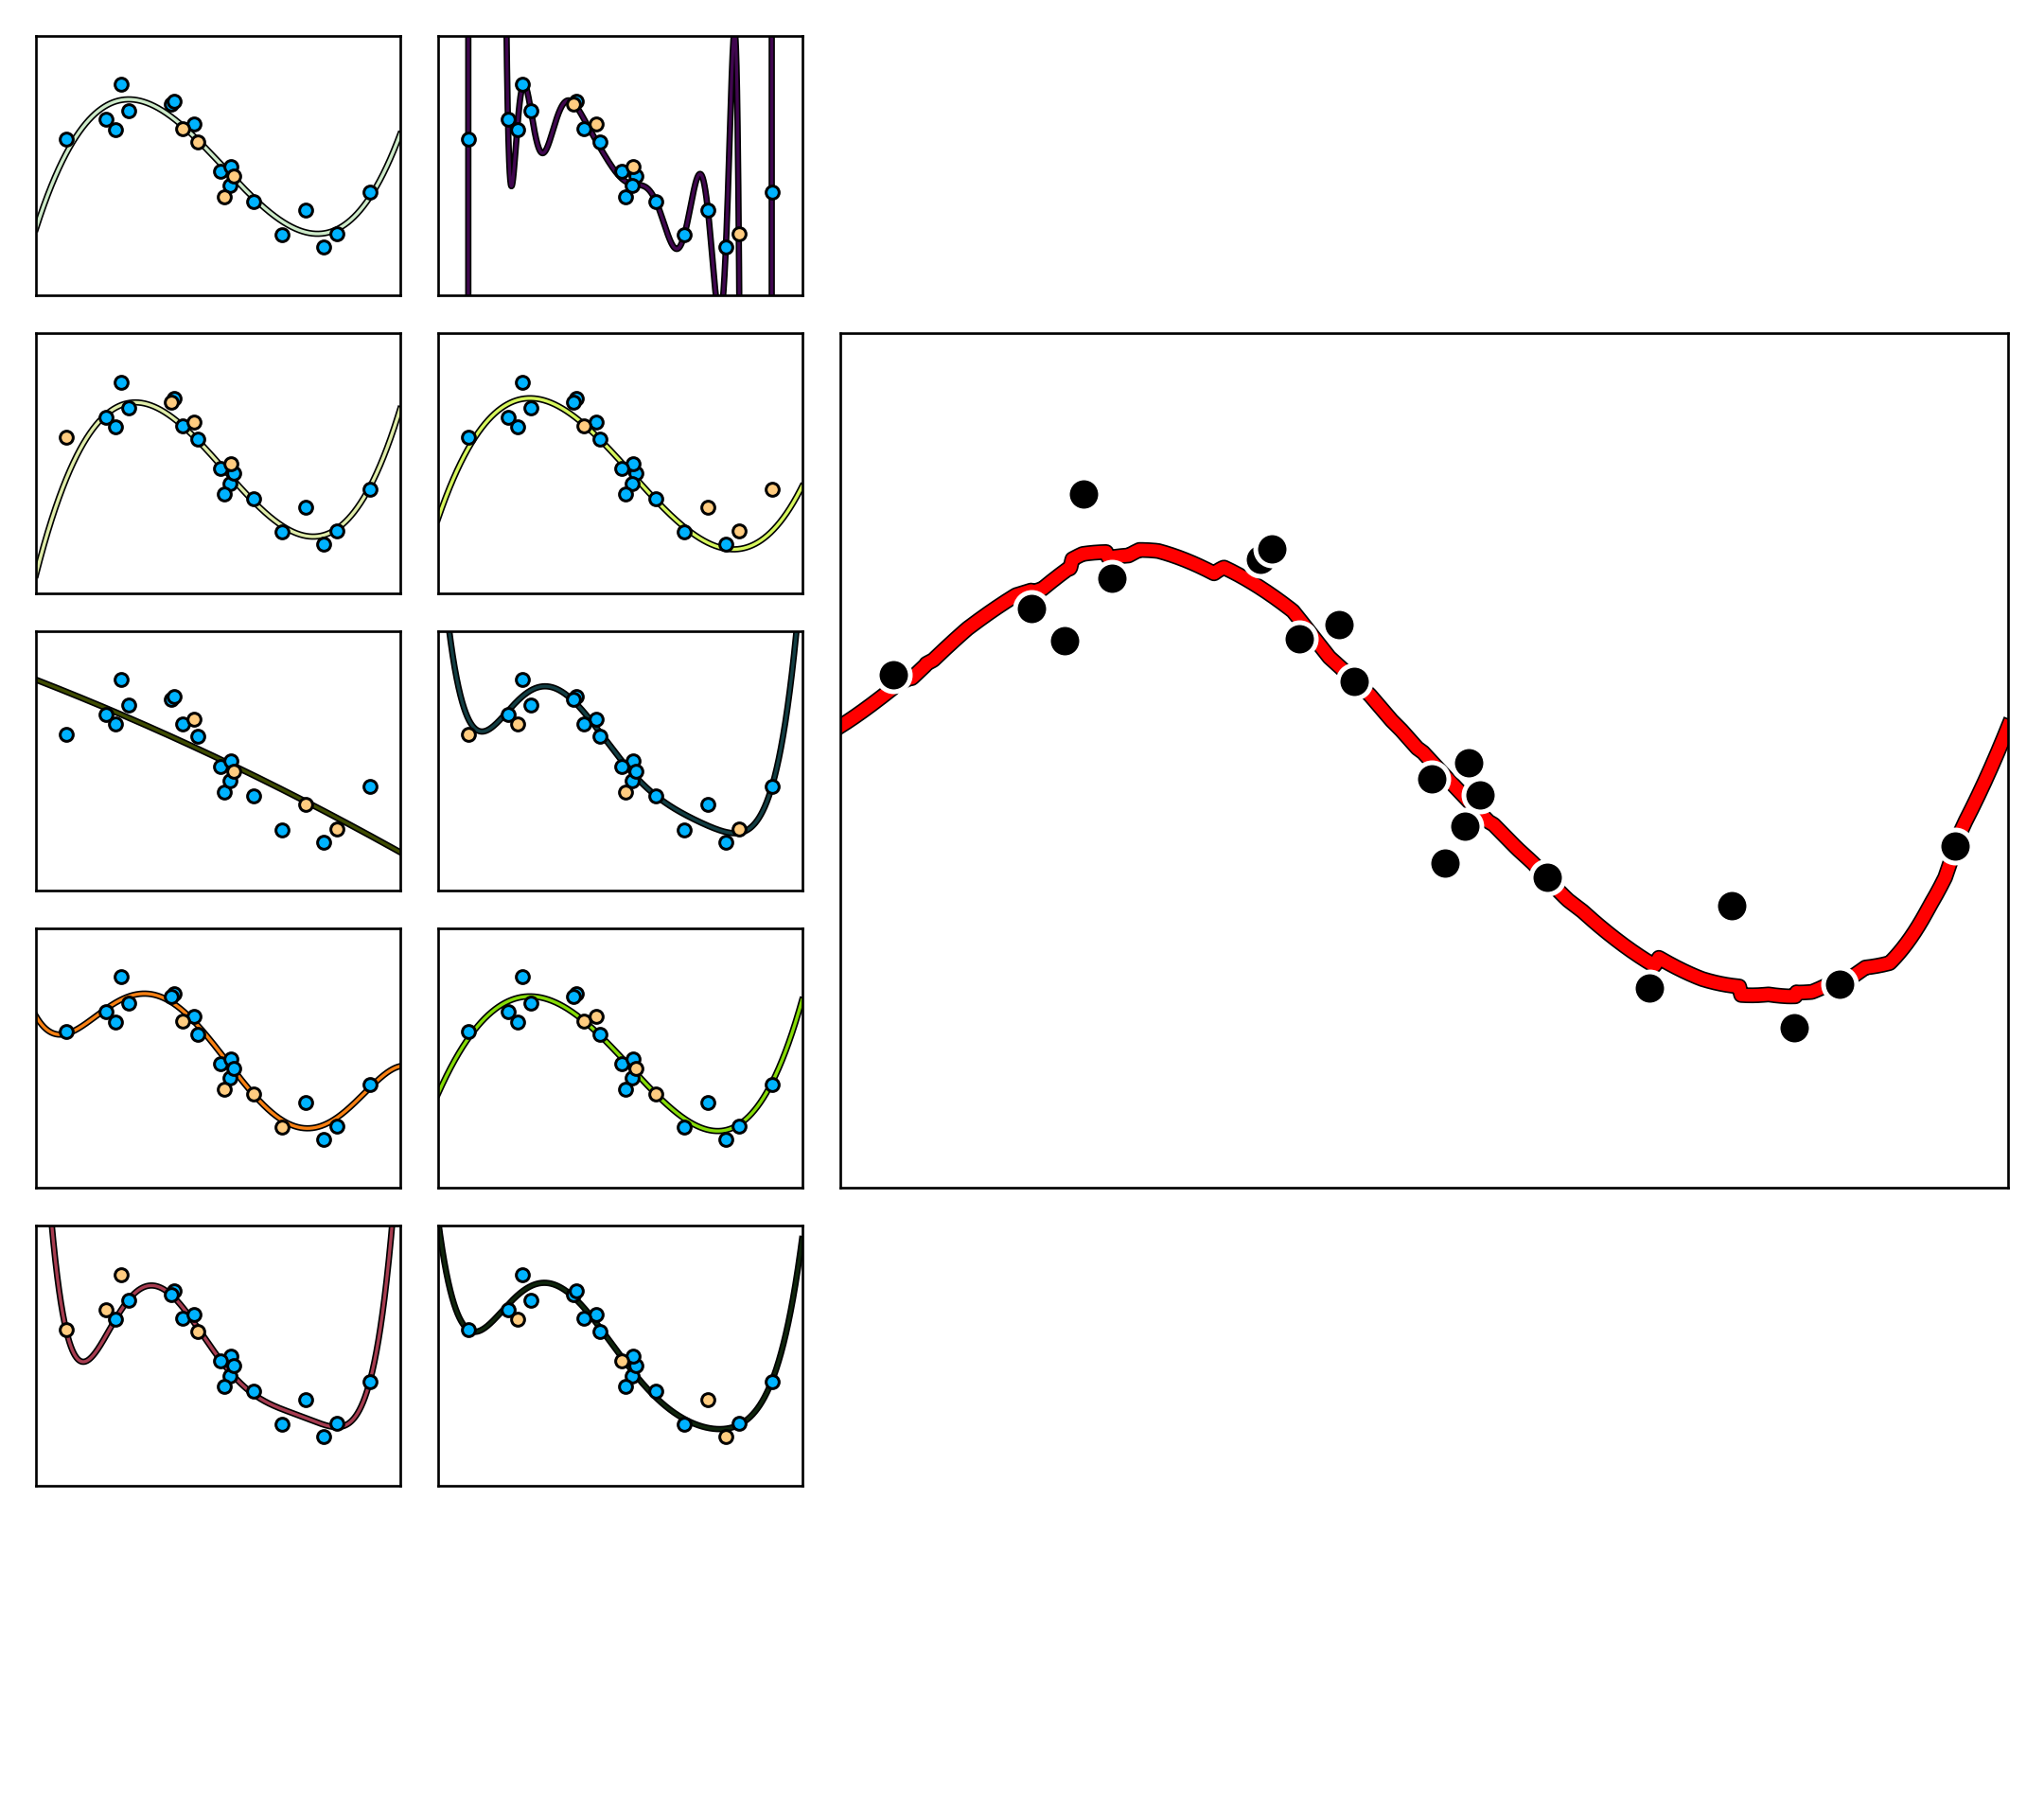

In [15]:
# This code cell will not be shown in the HTML version of this notebook
# import data
csvname_1 = datapath + 'noisy_sin_sample.csv'

data = np.loadtxt(csvname_1,delimiter = ',')
x = copy.deepcopy(data[:-1,:])
y = copy.deepcopy(data[-1:,:] )

### parameters for ensembling with regularized learner ###
train_portion = 0.8

### container for outer loop - contains best model per split ###
best_models_1 = []
num_splits = 10
top_degree = 20

### run inner loop - one split ###
for s in range(num_splits):
    #### outer loop - make a run over one split of the data ####
    runs = []
    w = 0
    for j in range(top_degree):
        # initialize with input/output data
        mylib1 = nonlib.reg_lib.super_setup.Setup(x,y)

        # perform preprocessing step(s) - especially input normalization
        mylib1.preprocessing_steps(normalizer = 'standard')

        # split into training and validation sets
        if j == 0:
            # make training testing split
            mylib1.make_train_val_split(train_portion = train_portion)
            train_inds = mylib1.train_inds
            valid_inds = mylib1.valid_inds

        else: # use split from first run for all further runs
            mylib1.x_train = mylib1.x[:,train_inds]
            mylib1.y_train = mylib1.y[:,train_inds]
            mylib1.x_valid = mylib1.x[:,valid_inds]
            mylib1.y_valid = mylib1.y[:,valid_inds]
            mylib1.train_inds = train_inds
            mylib1.valid_inds = valid_inds
            mylib1.train_portion = train_portion

        # choose cost
        mylib1.choose_cost(name = 'least_squares')

        # choose dimensions of fully connected multilayer perceptron layers
        mylib1.choose_features(name = 'polys',degree = j + 1)

        # fit an optimization
        mylib1.fit(algo = 'newtons_method',max_its = 1,verbose = False,epsilon = 10**(-10))

        # add model to list
        runs.append(copy.deepcopy(mylib1))
        
    ### keep lowest validation model from this run ###
    val_costs = [runs[i].valid_cost_histories[0][1] for i in range(top_degree)]
    min_ind = np.argmin(val_costs)
    min_val = val_costs[min_ind]
    best_model = runs[min_ind]

    # store 
    best_models_1.append(copy.deepcopy(best_model))
    
# plot each model individually, as well as the median model
demo1 = nonlib.regression_bagging_visualizers_v2.Visualizer(csvname_1)
demo1.show_runs(best_models_1)

Why average our cross-validated models using the *median* as opposed to say the *mean*?  Because the *mean* of a long list of numbers is far more sensitive to *outliers* than is the median.  In using the median of a large set of cross-validated models - and thus by using the median of their corresponding fits to the entire dataset - we ameliorate the effect of severely underfitting / overfitting cross-validated model on our final ensembled model.  Below we show the regression dataet above along with the individual cross-validated fits (left panel), the median ensembled model (middle panel), and the mean model (right panel).  Here the mean model is highly affected by the few overfitting models in the group, and ends up being far to oscillatory for the underlying data.  The median is not affected in this way, and is a much better representative.

<IPython.core.display.Javascript object>


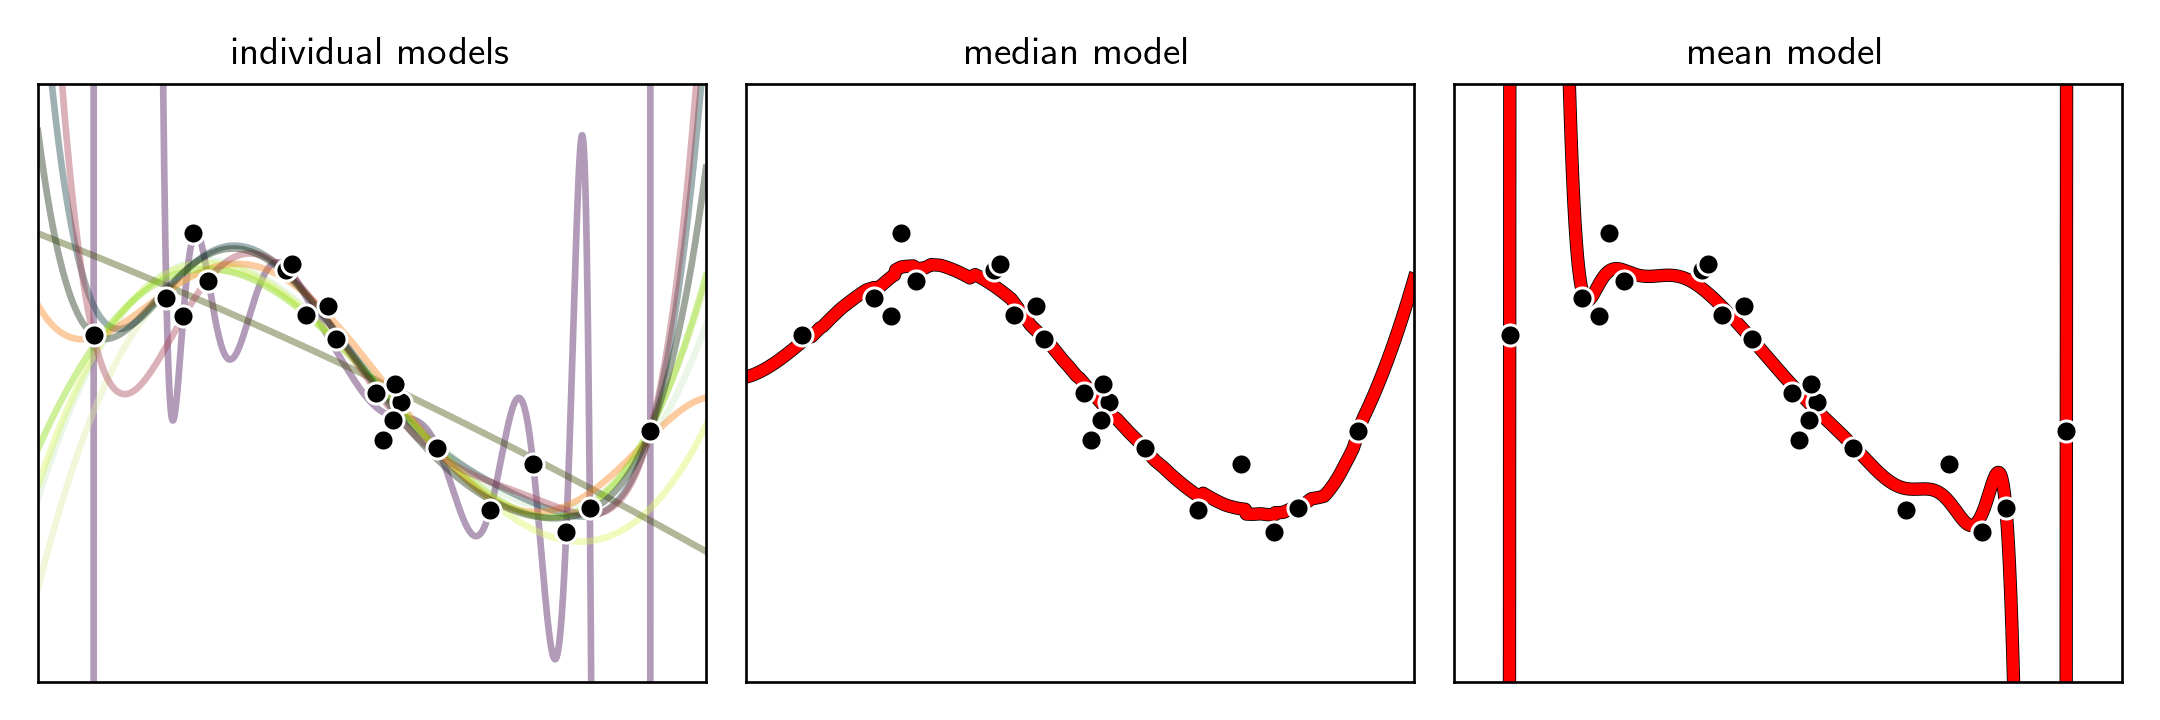

In [19]:
# This code cell will not be shown in the HTML version of this notebook
# show individual, median, and mean models for this dataset
demo1.show_baggs(best_models_1)

#### <span style="color:#a50e3e;">Example. 2 </span>  Mixing models built from different universal approximators

In ensembling we are simply averaging various cross-validated models with the desire to both avoid bad aspects of poorly performing models, and combining strong elements of the good performing ones.  Nothing in this notion prevents us from ensembling cross-validated models built using different universal approximators, and indeed this is the most organized way of combining different types of universal approximators in practice.

Below we show the result of a cross-validated polynomial model (left panel) built by comparing full polynomials of degree $1$ through $10$, a cross-validated neural network model (in the second to the left panel) built by comparing models consisting of $1$ through $10$ units, and a cross-validated stump model (second to the right panel) built via boosting.  Each cross-validated model uses a different training-validation split of the original dataset.  The ensemble (median) of these models is shown in the right panel.

<IPython.core.display.Javascript object>


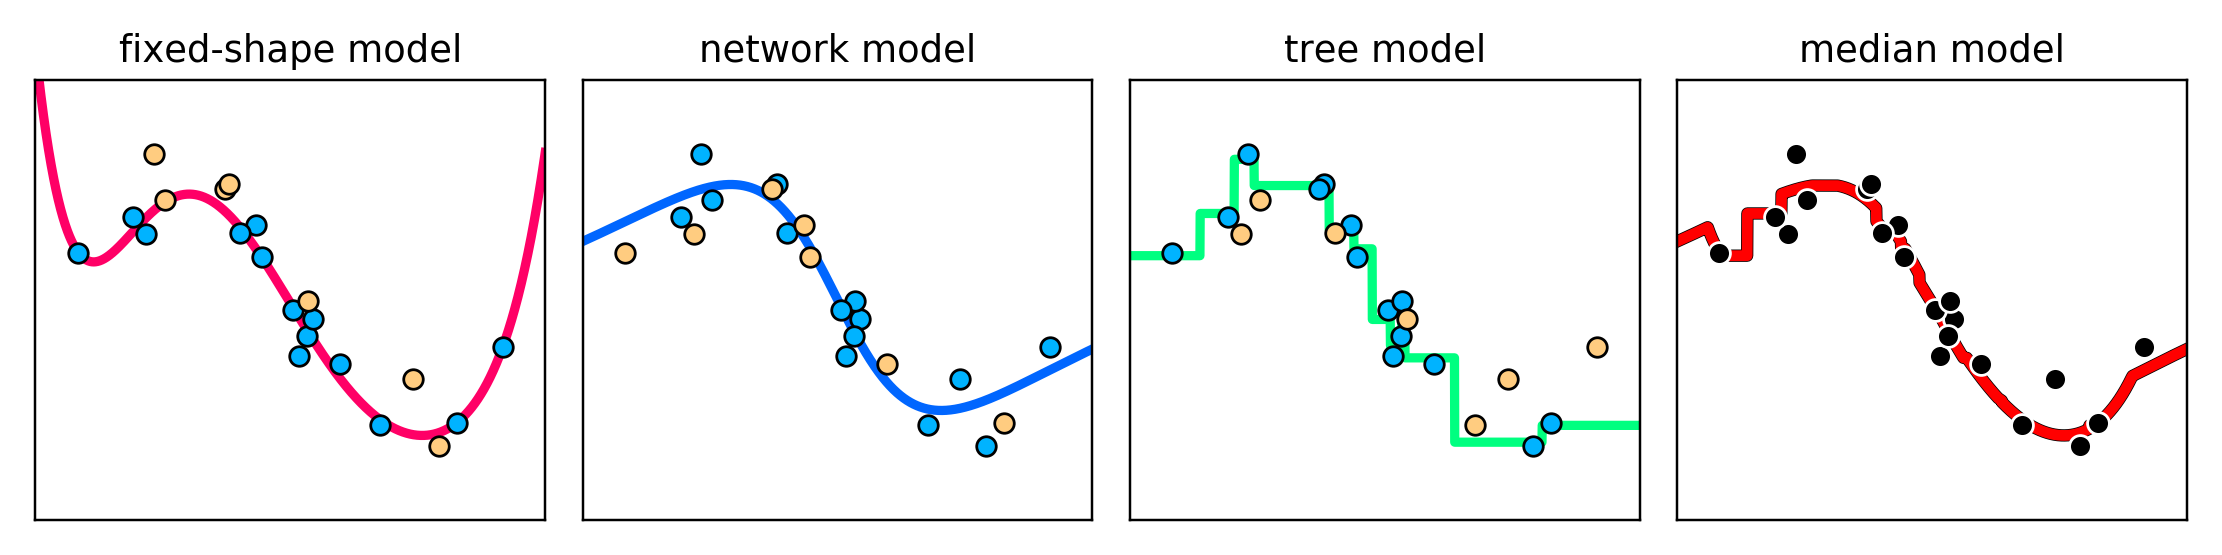

In [7]:
# This code cell will not be shown in the HTML version of this notebook
# import data
csvname_2 = datapath + 'noisy_sin_sample.csv'

data = np.loadtxt(csvname_2,delimiter = ',')
x = copy.deepcopy(data[:-1,:])
y = copy.deepcopy(data[-1:,:] )

### run kernel ###
### container for outer loop - contains best model per split ###
kernel_models = []
num_splits = 1
top_degree = 10
train_portion = 0.66

### run inner loop - one split ###
for s in range(num_splits):
    #### outer loop - make a run over one split of the data ####
    runs = []
    w = 0
    for j in range(top_degree):
        # initialize with input/output data
        mylib2 = nonlib.reg_lib.super_setup.Setup(x,y)

        # perform preprocessing step(s) - especially input normalization
        mylib2.preprocessing_steps(normalizer = 'standard')

        # split into training and validation sets
        if j == 0:
            # make training testing split
            mylib2.make_train_val_split(train_portion = train_portion)
            train_inds = mylib2.train_inds
            valid_inds = mylib2.valid_inds

        else: # use split from first run for all further runs
            mylib2.x_train = mylib2.x[:,train_inds]
            mylib2.y_train = mylib2.y[:,train_inds]
            mylib2.x_valid = mylib2.x[:,valid_inds]
            mylib2.y_valid = mylib2.y[:,valid_inds]
            mylib2.train_inds = train_inds
            mylib2.valid_inds = valid_inds
            mylib2.train_portion = train_portion

        # choose cost
        mylib2.choose_cost(name = 'least_squares')

        # choose dimensions of fully connected multilayer perceptron layers
        mylib2.choose_features(name = 'polys',degree = j + 1)

        # fit an optimization
        mylib2.fit(algo = 'newtons_method',max_its = 1,verbose = False)
    
        # add model to list
        runs.append(copy.deepcopy(mylib2))
        
    ### keep lowest validation model from this run ###
    val_costs = [runs[i].valid_cost_histories[0][1] for i in range(top_degree)]
    min_ind = np.argmin(val_costs)
    min_val = val_costs[min_ind]
    best_model = runs[min_ind]

    # store 
    kernel_models.append(copy.deepcopy(best_model))
    
### run neural network ###
### container for outer loop - contains best model per split ###
network_models = []
num_splits = 1
top_degree = 10
train_portion = 0.66

### run inner loop - one split ###
for s in range(num_splits):
    #### outer loop - make a run over one split of the data ####
    runs = []
    w = 0
    for j in range(top_degree):
        print (j)
        # initialize with input/output data
        mylib3 = nonlib.reg_lib.super_setup.Setup(x,y)

        # perform preprocessing step(s) - especially input normalization
        mylib3.preprocessing_steps(normalizer = 'standard')

        # split into training and validation sets
        if j == 0:
            # make training testing split
            mylib3.make_train_val_split(train_portion = train_portion)
            train_inds = mylib3.train_inds
            valid_inds = mylib3.valid_inds

        else: # use split from first run for all further runs
            mylib3.x_train = mylib3.x[:,train_inds]
            mylib3.y_train = mylib3.y[:,train_inds]
            mylib3.x_valid = mylib3.x[:,valid_inds]
            mylib3.y_valid = mylib3.y[:,valid_inds]
            mylib3.train_inds = train_inds
            mylib3.valid_inds = valid_inds
            mylib3.train_portion = train_portion

        # choose cost
        mylib3.choose_cost(name = 'least_squares')

        # choose dimensions of fully connected multilayer perceptron layers
        mylib3.choose_features(name = 'multilayer_perceptron',layer_sizes = [j],activation = 'tanh',scale = 0.1)

        # fit an optimization
        mylib3.fit(algo = 'gradient_descent',max_its = 2000,verbose = False,alpha_choice = 10**(-1))

        # add model to list
        runs.append(copy.deepcopy(mylib3))
        
    ### keep lowest validation model from this run ###
    val_costs = [np.min(runs[i].valid_cost_histories[0]) for i in range(top_degree)]
    min_ind = np.argmin(val_costs)
    min_val = val_costs[min_ind]
    best_model = runs[min_ind]

    # store 
    network_models.append(copy.deepcopy(best_model))
    
#### run tree booster ####
booster_models = []
num_booster_models = 1
runs = []
num_boost = 50
for i in range(num_booster_models):
    # import booster
    mylib4 = nonlib.boost_lib3.stump_booster.Setup(x,y)

    # choose normalizer
    mylib4.choose_normalizer(name = 'standard')

    # choose normalizer
    mylib4.make_train_valid_split(train_portion = 0.66)

    # choose cost|
    mylib4.choose_cost(name = 'least_squares')

    # choose optimizer
    mylib4.choose_optimizer('newtons_method',max_its=1)

    # run boosting
    mylib4.boost(num_boost)

    # determine best booster based on validation error
    val_costs = mylib4.valid_cost_vals
    min_ind = np.argmin(val_costs)

    best = mylib4.models[min_ind]
    mylib4.model = best
    booster_models.append(copy.deepcopy(mylib4))
    
# plot each model individually, as well as the median model
demo2 = nonlib.regression_bagging_visualizers_mixed.Visualizer(csvname_2)
demo2.show_baggs(kernel_models,network_models,booster_models)

## 11.5.2  Ensembling cross-validated classification models

The principle behind ensembling cross-validated models holds analagously for classification tasks as well.  Because we cannot be certain whether or not a certain (randomly chosen) validation set accurately represents the 'future data' from a given phenomenon, the averaging (or ensembling) of a number of cross-validated classification models provides a way of 'averaging out' poorly representative portions of some models while combining the models' positive traits.   

Because the output of a (cross-validated) classification model is transformed into a *discrete* label - via e.g., passing the model through $\text{sign}$ function in the case of two-class classification (when employing label values $y\in\left\{-1,+1\right\}$ or the *fusion rule* in the multi-class setting - *average cross-validated classification models is by taking their mode (i.e., the most popularly predicted label)*.  

#### <span style="color:#a50e3e;">Example 3. </span>  Ensembling cross-validated two-class classification models 

In the set of small panels in the left below we show $5$ different training-validation splits of our prototypical two-class classification dataset, where $\frac{2}{3}$ of the data in each instance is used for training and $\frac{1}{3}$ is used for validation (the edges of these points are colored yellow), first introduced in Section 10.2.1.  Plotted with each split of the original data is the corresponding cross-validated model found by trying out the range of complete polynomial models of degree $1$ to $8$.  *Many* of these cross-validated models perform quite well, but several of them (due to the particular training-validation split on which they are based) severly  *overfit* the original dataset.  By using the most popular prediction to assign labels - i.e., the *mode* of these cross-validated model predictions - we produce an appropriate decision boundary for the data (as shown in the right panel).

<IPython.core.display.Javascript object>


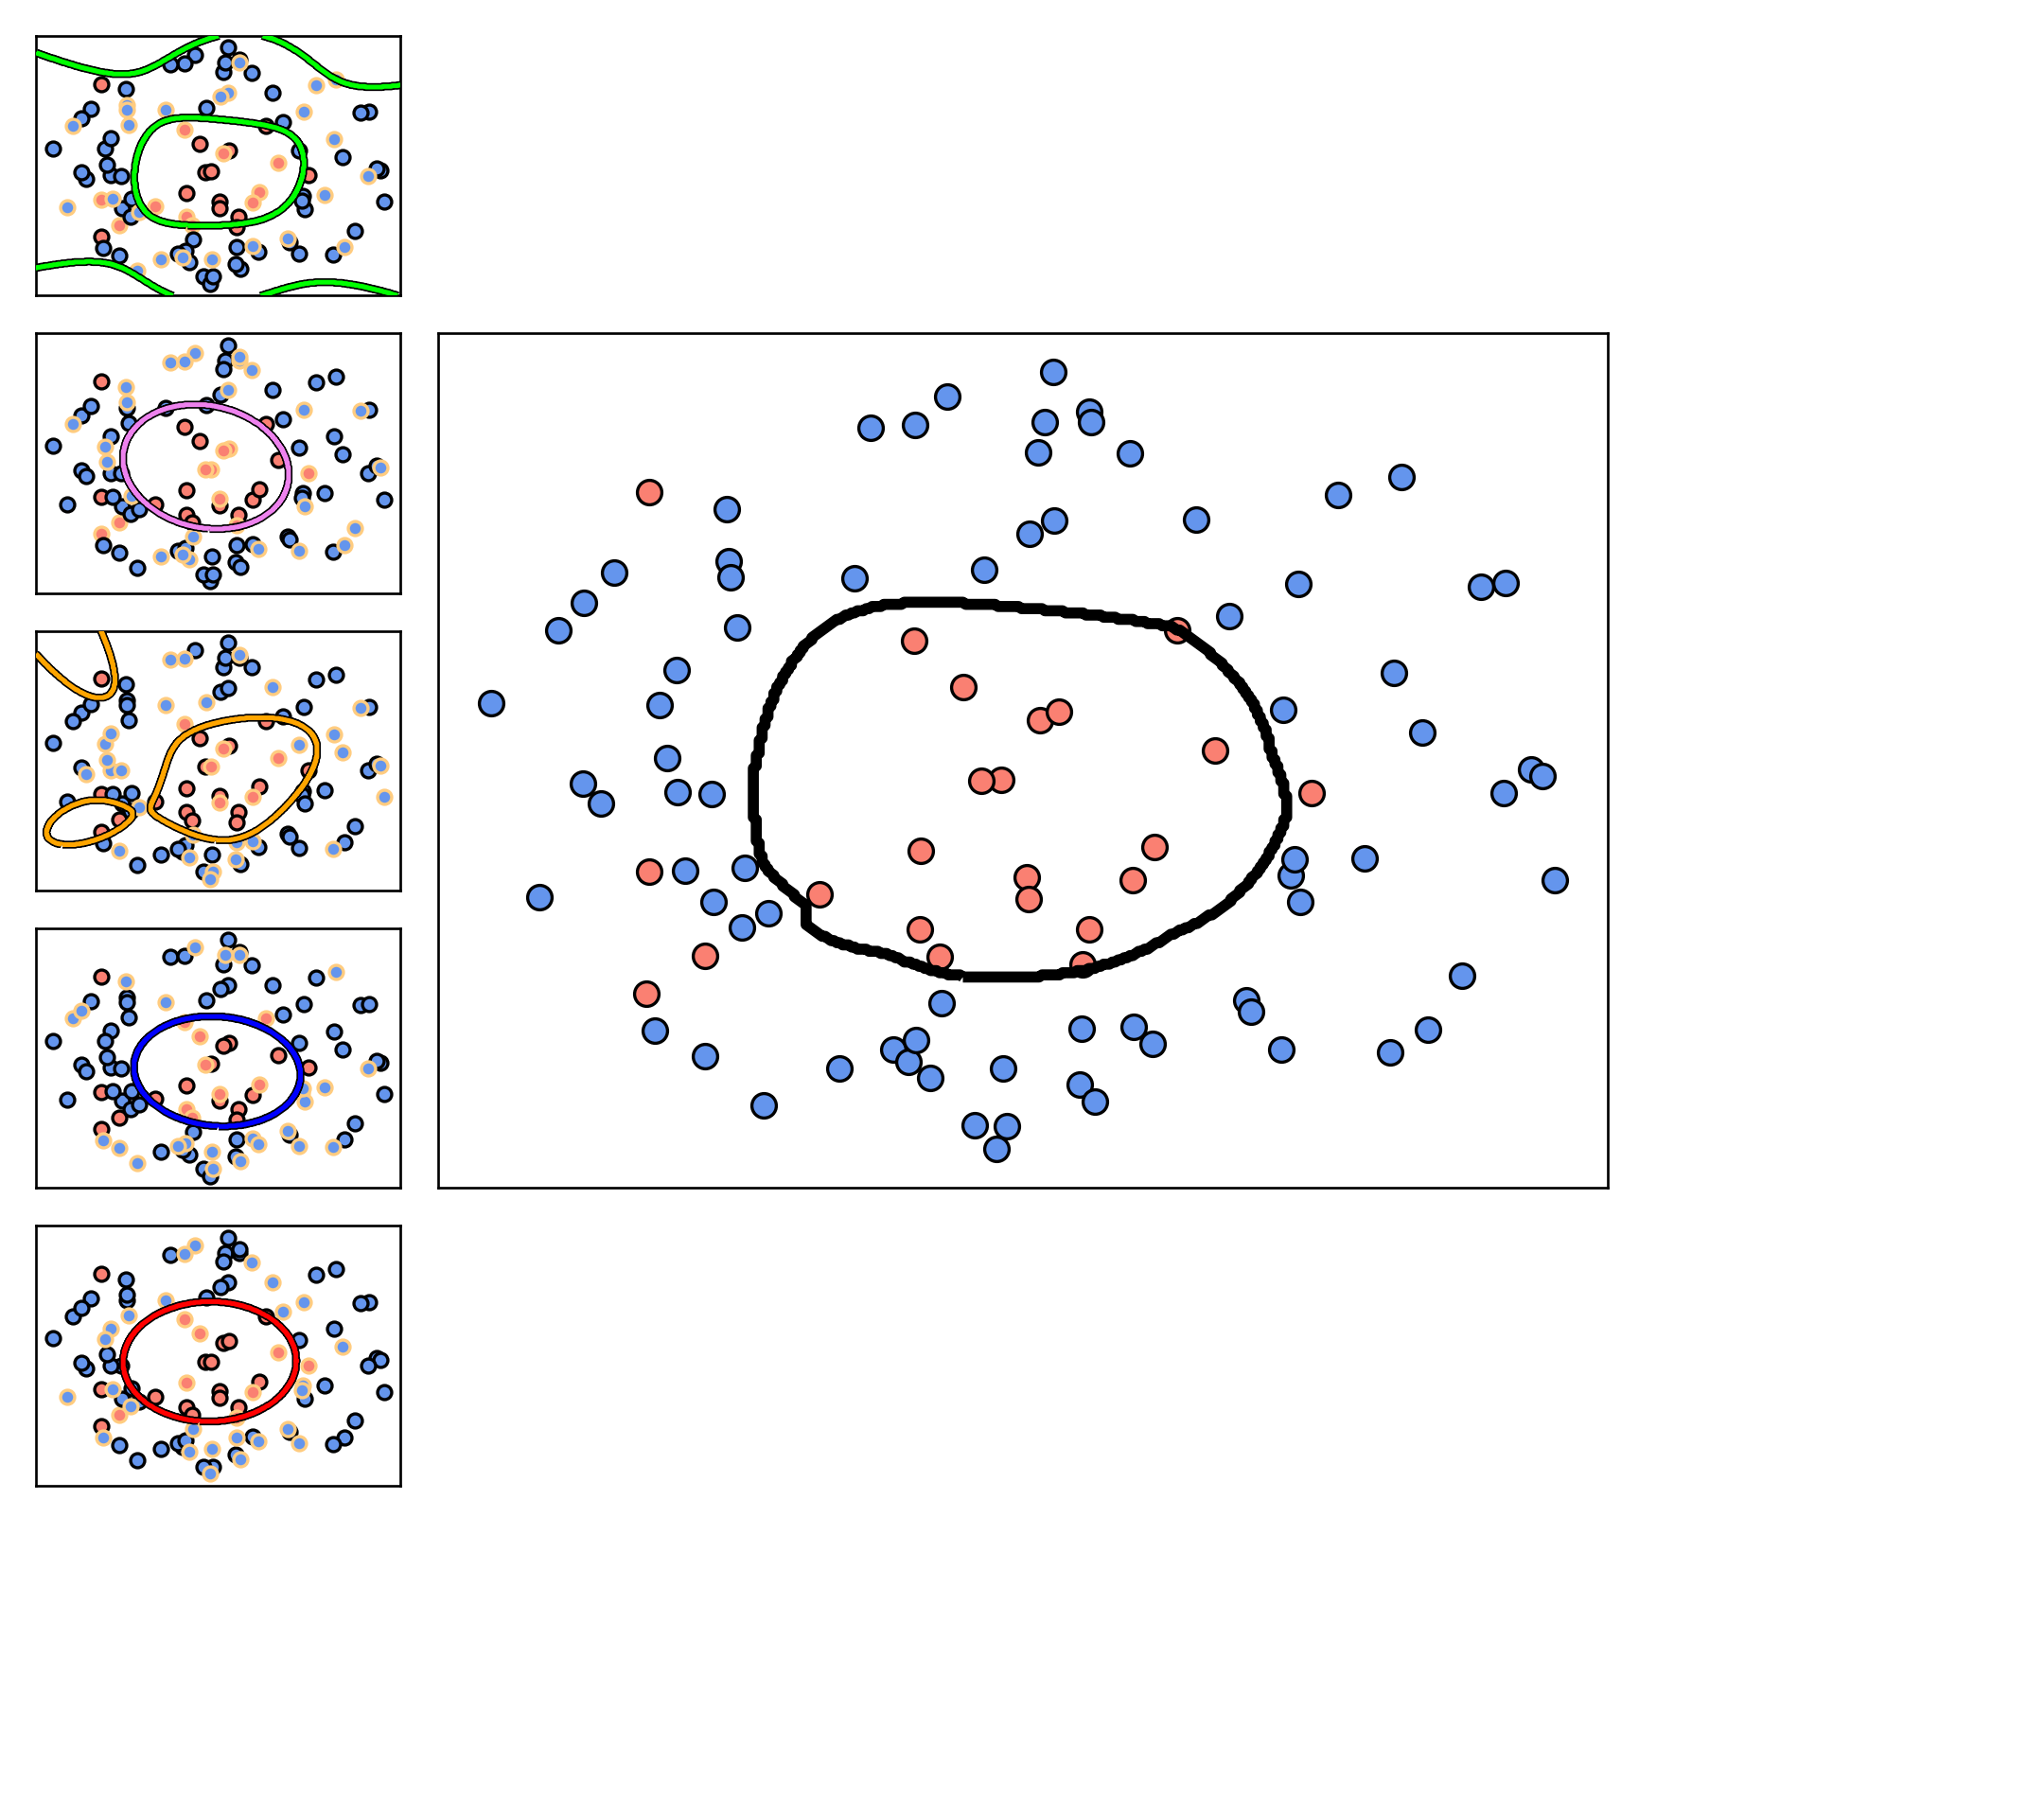

In [22]:
# This code cell will not be shown in the HTML version of this notebook
# load in dataset
csvname_3 = datapath + 'new_circle_data.csv'

data = np.loadtxt(csvname_3,delimiter = ',')
x = data[:-1,:]
y = data[-1:,:] 

# run bagg
degree = 8
num_baggs = 5
train_portion = 0.66
best_models_4 = []
runs = []
for j in range(num_baggs):
    # initialize with input/output data
    mylib5 = nonlib.reg_lib.super_setup.Setup(x,y)

    # perform preprocessing step(s) - especially input normalization
    mylib5.preprocessing_steps(normalizer = 'none')
    
    # pluck out indices of current training / validation sets
    mylib5.make_train_val_split(train_portion = train_portion)
    
    # loop over models to try
    for d in range(1,degree+1):
        # choose cost
        mylib5.choose_cost(name = 'softmax')

        # choose dimensions of fully connected multilayer perceptron layers
        mylib5.choose_features(name = 'polys',degree = d)

        # fit an optimization
        mylib5.fit(algo = 'newtons_method',max_its = 10,verbose = False,lam = 10**(-8))
        
    # keep only the best degree, based on lowest validation cost
    val_costs = [np.min(mylib5.valid_count_histories[i]) for i in range(degree)]
    min_ind = np.argmin(val_costs)
    min_val = val_costs[min_ind]
    
    # get minor of minor
    smallest_ind = np.argmin(mylib5.valid_count_histories[min_ind])
    mylib5.train_cost_histories = mylib5.train_cost_histories[min_ind][smallest_ind]
    mylib5.valid_cost_histories = mylib5.valid_cost_histories[min_ind][smallest_ind]
    mylib5.train_count_histories = mylib5.train_count_histories[min_ind][smallest_ind]
    mylib5.valid_count_histories = mylib5.valid_count_histories[min_ind][smallest_ind]
    mylib5.weight_histories = mylib5.weight_histories[min_ind][smallest_ind]
    mylib5.choose_features(name = 'polys',degree = min_ind + 1)

    # store 
    best_models_4.append(copy.deepcopy(mylib5))
    
# draw pics
demo3 = nonlib.classification_bagging_visualizers_v2.Visualizer(csvname_3)
demo3.show_runs(best_models_4)

In the next example below we illustrate the result of $5$ cross-validated models each built using $B = 20$ single layer $\text{tanh}$ units trained on different training / validation splits of the dataset shown below in the left panel.  In each instance $\frac{1}{3}$ of the dataset is randomly chosen as validation, and the appropriate tuning of each model's parameters is achieved via $\ell_2$ regularization using a dense range of values for $\lambda \in [0,0.1]$.  In the middle panel we plot the diverse set of decision boundaries associated to each cross-validated model on top of the originaln dataset, each colored differently so they can be distinguished visually.  While some of these decision boundaries separate the two classes quite well, others do a poorer job.  In the right panel we show the decision boundary of the ensemble, created by taking the mode of the predictions from these cross-validated models, which performs quite well.

<IPython.core.display.Javascript object>


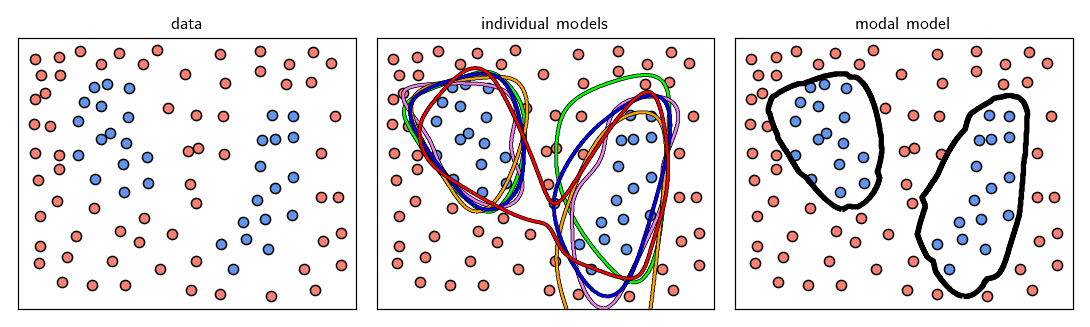

In [15]:
# This code cell will not be shown in the HTML version of this notebook
# load in dataset
csvname_4 = datapath + '2_eggs.csv'
data = np.loadtxt(csvname_4,delimiter = ',')
x = data[:-1,:]
y = data[-1:,:] 

# bags
num_baggs = 5

# start process
num_lams = 20
train_portion = 0.66
lambdas = np.linspace(0,0.1,num_lams)
best_models_5 = []
for t in range(num_baggs):    
    # initialize with input/output data
    mylib6 = nonlib.reg_lib.super_setup.Setup(x,y)

    # perform preprocessing step(s) - especially input normalization
    mylib6.preprocessing_steps(normalizer = 'standard')

    # make training validation split
    mylib6.make_train_val_split(train_portion = train_portion)
            
    # choose cost
    mylib1.choose_cost(name = 'softmax')
    
    # choose dimensions of fully connected multilayer perceptron layers
    mylib6.choose_features(name = 'multilayer_perceptron',layer_sizes = [20],activation = 'tanh',scale = 0.1)
        
    # loop over lambda choices
    w = 0
    for j in range(num_lams):
        lam = lambdas[j]
        
        # optimize
        mylib6.fit(algo = 'gradient_descent',max_its = 2000,verbose = False,lam = lam,alpha_choice = 10**(0))
        
    # keep only the best degree, based on lowest validation cost
    val_costs = [np.min(mylib6.valid_count_histories[i]) for i in range(num_lams)]
    min_ind = np.argmin(val_costs)
    min_val = val_costs[min_ind]
    
    # get minor of minor
    smallest_ind = np.argmin(mylib6.valid_count_histories[min_ind])
    mylib6.train_cost_histories = mylib6.train_cost_histories[min_ind][smallest_ind]
    mylib6.valid_cost_histories = mylib6.valid_cost_histories[min_ind][smallest_ind]
    mylib6.train_count_histories = mylib6.train_count_histories[min_ind][smallest_ind]
    mylib6.valid_count_histories = mylib6.valid_count_histories[min_ind][smallest_ind]
    mylib6.weight_histories = mylib6.weight_histories[min_ind][smallest_ind]

    # store 
    best_models_5.append(copy.deepcopy(mylib6))
    
# draw pics
demo4 = nonlib.classification_bagging_visualizers_v2.Visualizer(csvname_4)
demo4.show_baggs(best_models_5)

#### <span style="color:#a50e3e;">Example. 4 </span>  Mixing models built from different universal approximators

As with regression, with classification we can also combine cross-validated models built from different universal approximators.  We illustrate this using the two-class dataset introduced in the prior Example.

Below we show the result of a cross-validated polynomial model (left panel) built by comparing full polynomials of degree $1$ through $10$, a cross-validated neural network model (in the second to the left panel) built by comparing models consisting of $1$ through $10$ units, and a cross-validated stump model (second to the right panel) built via boosting over a range of $20$ units.  Each cross-validated model uses a different training-validation split of the original dataset.  The ensemble (mode) of these models is shown in the right panel.

<IPython.core.display.Javascript object>


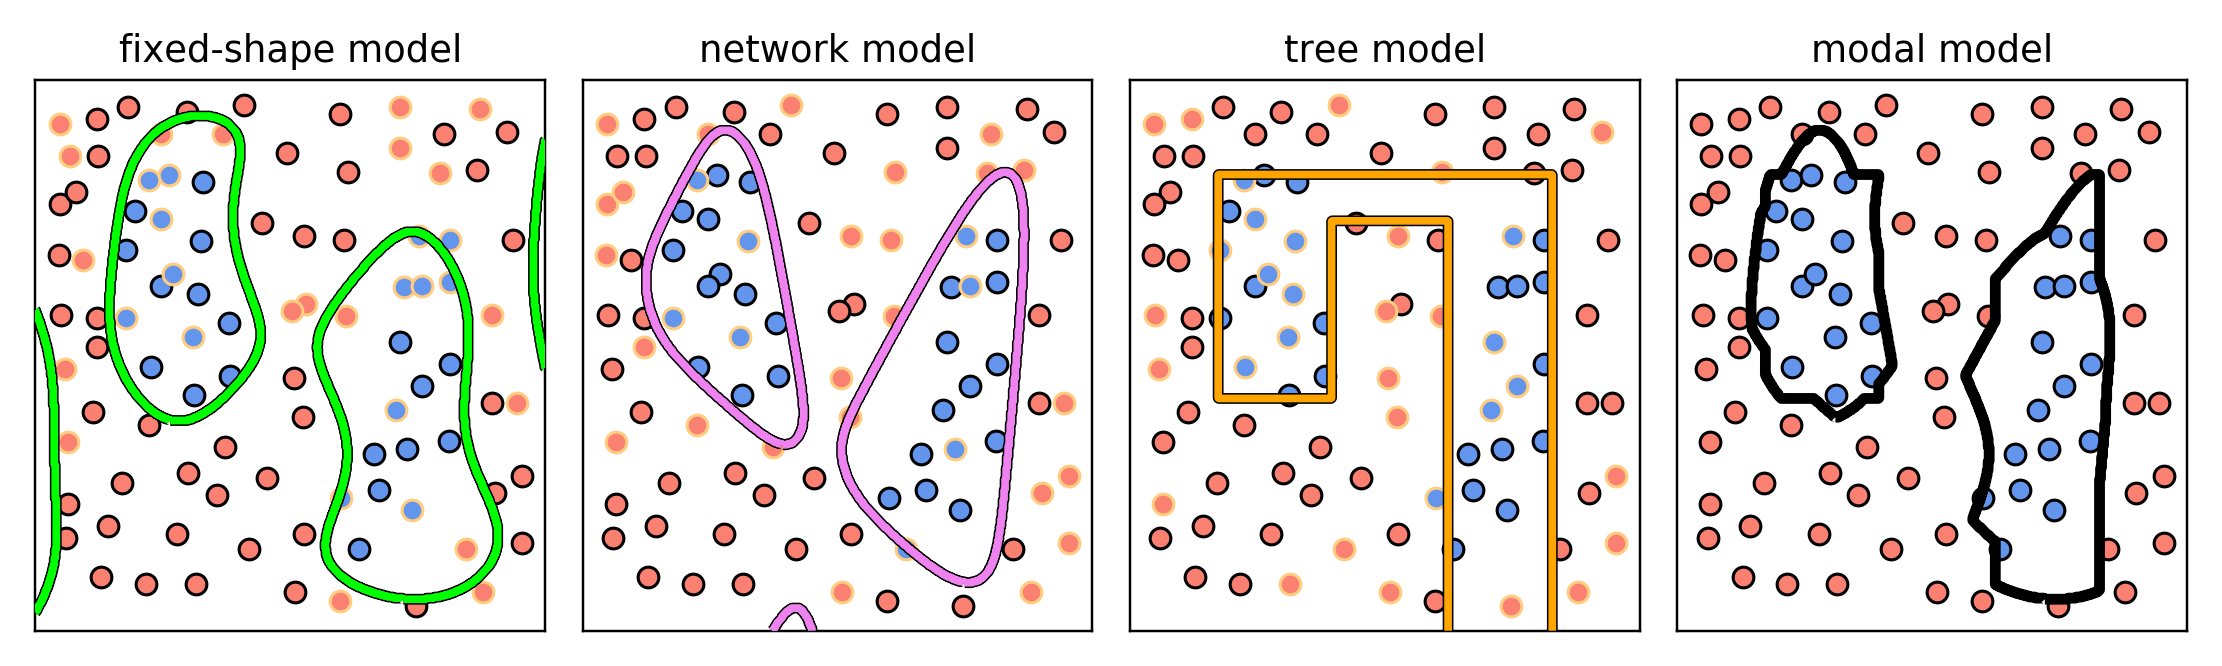

In [37]:
# This code cell will not be shown in the HTML version of this notebook
# import data
csvname_2 = datapath + 'new_circle_data.csv'
csvname_2 = datapath + '2_eggs.csv'

data = np.loadtxt(csvname_2,delimiter = ',')
x = copy.deepcopy(data[:-1,:])
y = copy.deepcopy(data[-1:,:] )

### run kernel ###
### container for outer loop - contains best model per split ###
kernel_models = []
num_splits = 1
top_degree = 10
train_portion = 0.66

### run inner loop - one split ###
for s in range(num_splits):
    #### outer loop - make a run over one split of the data ####
    runs = []
    w = 0
    for j in range(top_degree):
        # initialize with input/output data
        mylib2 = nonlib.reg_lib.super_setup.Setup(x,y)

        # perform preprocessing step(s) - especially input normalization
        mylib2.preprocessing_steps(normalizer = 'standard')

        # split into training and validation sets
        if j == 0:
            # make training testing split
            mylib2.make_train_val_split(train_portion = train_portion)
            train_inds = mylib2.train_inds
            valid_inds = mylib2.valid_inds

        else: # use split from first run for all further runs
            mylib2.x_train = mylib2.x[:,train_inds]
            mylib2.y_train = mylib2.y[:,train_inds]
            mylib2.x_valid = mylib2.x[:,valid_inds]
            mylib2.y_valid = mylib2.y[:,valid_inds]
            mylib2.train_inds = train_inds
            mylib2.valid_inds = valid_inds
            mylib2.train_portion = train_portion

        # choose cost
        mylib2.choose_cost(name = 'softmax')

        # choose dimensions of fully connected multilayer perceptron layers
        mylib2.choose_features(name = 'polys',degree = j + 1)

        # fit an optimization
        mylib2.fit(algo = 'newtons_method',max_its = 1,verbose = False)
    
        # add model to list
        runs.append(copy.deepcopy(mylib2))
        
    ### keep lowest validation model from this run ###
    val_costs = [runs[i].valid_cost_histories[0][1] for i in range(top_degree)]
    min_ind = np.argmin(val_costs)
    min_val = val_costs[min_ind]
    best_model = runs[min_ind]

    # store 
    kernel_models.append(copy.deepcopy(best_model))

### run neural network ###
### container for outer loop - contains best model per split ###
network_models = []
num_splits = 1
top_degree = 10

### run inner loop - one split ###
for s in range(num_splits):
    #### outer loop - make a run over one split of the data ####
    runs = []
    w = 0
    for j in range(top_degree):
        print (j)
        # initialize with input/output data
        mylib3 = nonlib.reg_lib.super_setup.Setup(x,y)

        # perform preprocessing step(s) - especially input normalization
        mylib3.preprocessing_steps(normalizer = 'standard')

        # split into training and validation sets
        if j == 0:
            # make training testing split
            mylib3.make_train_val_split(train_portion = train_portion)
            train_inds = mylib3.train_inds
            valid_inds = mylib3.valid_inds

        else: # use split from first run for all further runs
            mylib3.x_train = mylib3.x[:,train_inds]
            mylib3.y_train = mylib3.y[:,train_inds]
            mylib3.x_valid = mylib3.x[:,valid_inds]
            mylib3.y_valid = mylib3.y[:,valid_inds]
            mylib3.train_inds = train_inds
            mylib3.valid_inds = valid_inds
            mylib3.train_portion = train_portion

        # choose cost
        mylib3.choose_cost(name = 'softmax')

        # choose dimensions of fully connected multilayer perceptron layers
        mylib3.choose_features(name = 'multilayer_perceptron',layer_sizes = [j],activation = 'tanh',scale = 0.1)

        # fit an optimization
        mylib3.fit(algo = 'gradient_descent',max_its = 2000,verbose = False,alpha_choice = 10**(0))

        # add model to list
        runs.append(copy.deepcopy(mylib3))
        
    ### keep lowest validation model from this run ###
    val_costs = [np.min(runs[i].valid_count_histories[0]) for i in range(top_degree)]
    min_ind = np.argmin(val_costs)
    min_val = val_costs[min_ind]
    best_model = runs[min_ind]

    # store 
    network_models.append(copy.deepcopy(best_model))
    
#### run stump booster ####
booster_models = []
num_booster_models = 1
runs = []
num_boost = 20
for i in range(num_booster_models):
    # import booster
    mylib4 = nonlib.boost_lib3.stump_booster.Setup(x,y)

    # choose normalizer
    mylib4.choose_normalizer(name = 'standard')

    # choose normalizer
    mylib4.make_train_valid_split(train_portion = 0.66)

    # choose cost|
    mylib4.choose_cost(name = 'softmax')

    # choose optimizer
    mylib4.choose_optimizer('newtons_method',max_its=1)

    # run boosting
    mylib4.boost(num_boost)

    # determine best booster based on validation error
    val_costs = mylib4.valid_cost_vals
    min_ind = np.argmin(val_costs)

    best = mylib4.models[min_ind]
    mylib4.model = best
    booster_models.append(copy.deepcopy(mylib4))
    
# plot each model individually, as well as the median model
demo2 = nonlib.classification_bagging_visualizers_mixed.Visualizer(csvname_2)
demo2.show_baggs(kernel_models,network_models,booster_models)

#### <span style="color:#a50e3e;">Example. 5 </span>  Ensembling multi-class models

In this example we illustrate the ensembling of various cross-validated multi-class models on a range of different toy datasets.  In each case a full polynomial of degree $1$ through $5$ was tested for each cross-validated model, with $5$ cross-validated models learned in total.  For each dataset the decision boundary provided by each cross-validated model is shown in the middle panel, while the decision boundary of the final modal ensemble is shown in the right panel.

<IPython.core.display.Javascript object>


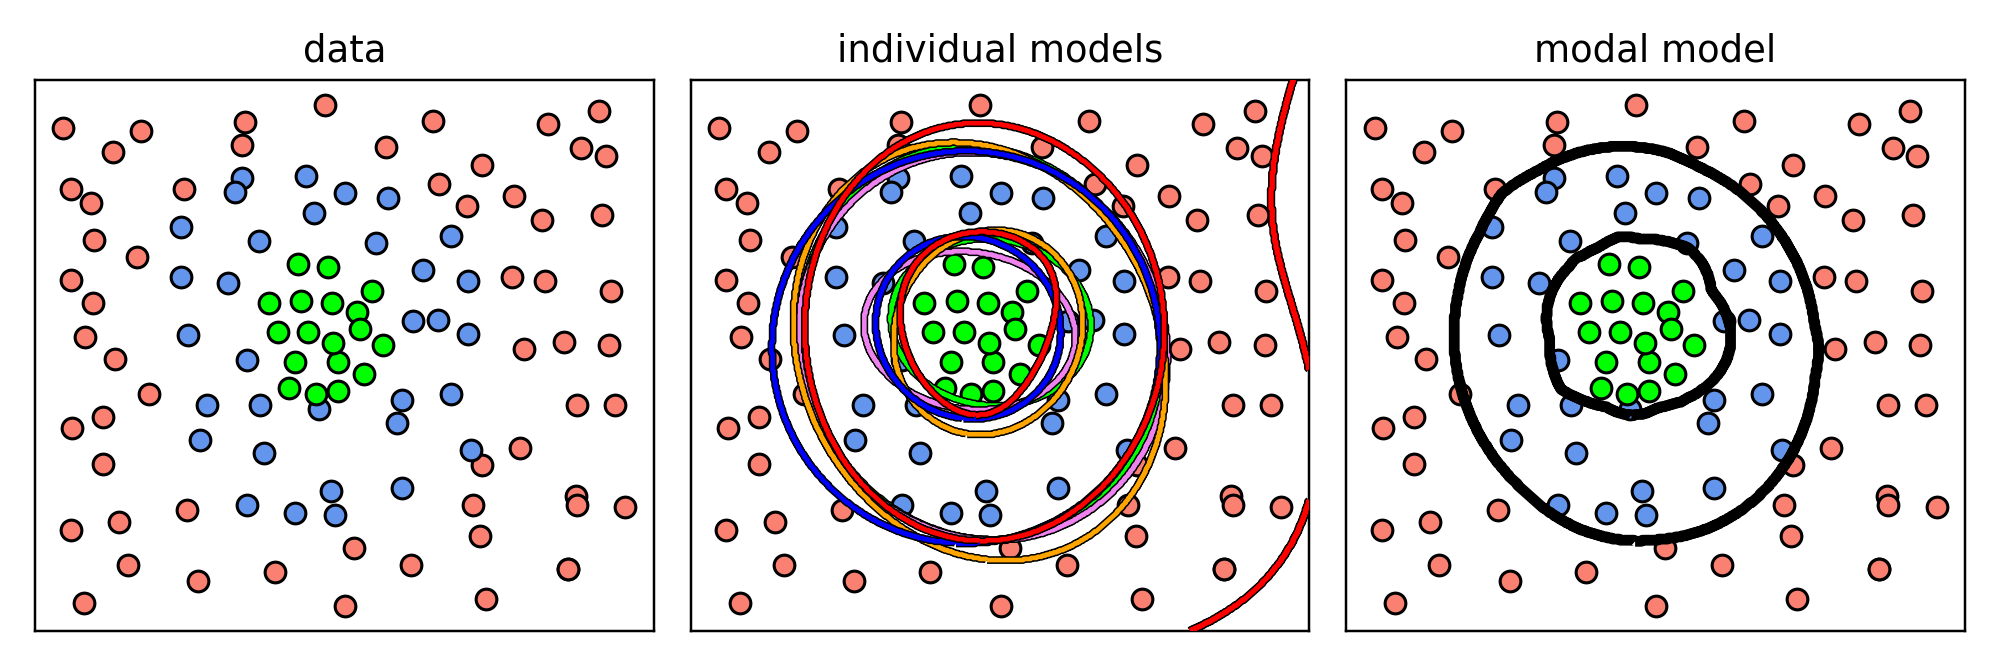

In [42]:
# This code cell will not be shown in the HTML version of this notebook
# load in dataset
csvname = datapath + '3_layercake_data.csv'

data = np.loadtxt(csvname,delimiter = ',')
x = data[:-1,:]
y = data[-1:,:] 

# run bagg
degree = 10
num_baggs = 5
train_portion = 0.66
runs6 = []
for j in range(num_baggs):
    # initialize with input/output data
    mylib6 = nonlib.reg_lib.super_setup.Setup(x,y)

    # perform preprocessing step(s) - especially input normalization
    mylib6.preprocessing_steps(name = 'standard')
    
    # pluck out indices of current training / validation sets
    mylib6.make_train_val_split(train_portion = train_portion)
    
    # loop over models to try
    for d in range(1,degree+1):
        # choose cost
        mylib6.choose_cost(name = 'multiclass_softmax')

        # choose dimensions of fully connected multilayer perceptron layers
        mylib6.choose_features(name = 'polys',degree = d,num_classifiers = 4)
        
        # fit an optimization
        mylib6.fit(algo = 'newtons_method',max_its = 5,verbose = False,lam = 10**(-6))
        
    # keep only the best degree, based on lowest validation cost
    val_costs = [np.min(mylib6.valid_count_histories[i]) for i in range(degree)]
    min_ind = np.argmin(val_costs)
    min_val = val_costs[min_ind]
    
    # get minor of minor
    smallest_ind = np.argmin(mylib6.valid_count_histories[min_ind])
    mylib6.train_cost_histories = mylib6.train_cost_histories[min_ind][smallest_ind]
    mylib6.valid_cost_histories = mylib6.valid_cost_histories[min_ind][smallest_ind]
    mylib6.train_count_histories = mylib6.train_count_histories[min_ind][smallest_ind]
    mylib6.valid_count_histories = mylib6.valid_count_histories[min_ind][smallest_ind]
    mylib6.weight_histories = mylib6.weight_histories[min_ind][smallest_ind]
    mylib6.choose_features(name = 'polys',degree = min_ind + 1)
        
    # store 
    runs6.append(copy.deepcopy(mylib6))
    
# draw pics
demo4 = nonlib.multiclass_bagging_visualizers.Visualizer(csvname)
demo4.show_baggs(runs6)

<IPython.core.display.Javascript object>


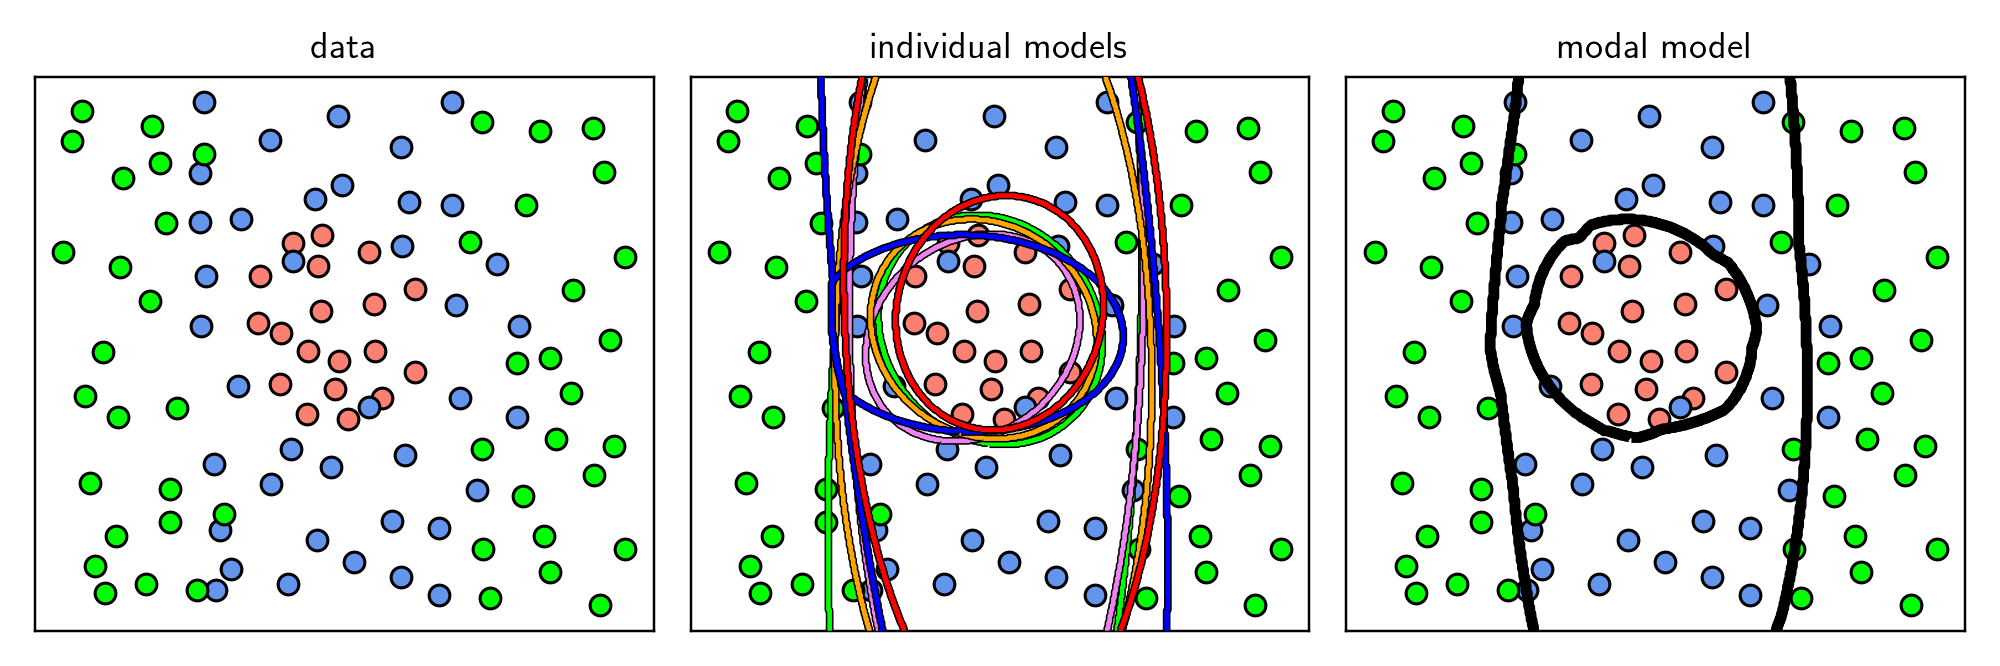

In [17]:
# This code cell will not be shown in the HTML version of this notebook
# load in dataset
csvname = datapath + '3class_egg_inside.csv'

data = np.loadtxt(csvname,delimiter = ',')
x = data[:-1,:]
y = data[-1:,:] 

# run bagg
degree = 5
num_baggs = 5
train_portion = 0.66
runs6 = []
for j in range(num_baggs):
    # initialize with input/output data
    mylib6 = nonlib.reg_lib.super_setup.Setup(x,y)

    # perform preprocessing step(s) - especially input normalization
    mylib6.preprocessing_steps(name = 'standard')
    
    # pluck out indices of current training / validation sets
    mylib6.make_train_val_split(train_portion = train_portion)
    
    # loop over models to try
    for d in range(1,degree+1):
        # choose cost
        mylib6.choose_cost(name = 'multiclass_softmax')

        # choose dimensions of fully connected multilayer perceptron layers
        mylib6.choose_features(name = 'polys',degree = d,num_classifiers = 3)
        
        # fit an optimization
        mylib6.fit(algo = 'newtons_method',max_its = 15,verbose = False,lam = 10**(-8))
        
    # keep only the best degree, based on lowest validation cost
    val_costs = [np.min(mylib6.valid_count_histories[i]) for i in range(degree)]
    min_ind = np.argmin(val_costs)
    min_val = val_costs[min_ind]
    
    # get minor of minor
    smallest_ind = np.argmin(mylib6.valid_count_histories[min_ind])
    mylib6.train_cost_histories = mylib6.train_cost_histories[min_ind][smallest_ind]
    mylib6.valid_cost_histories = mylib6.valid_cost_histories[min_ind][smallest_ind]
    mylib6.train_count_histories = mylib6.train_count_histories[min_ind][smallest_ind]
    mylib6.valid_count_histories = mylib6.valid_count_histories[min_ind][smallest_ind]
    mylib6.weight_histories = mylib6.weight_histories[min_ind][smallest_ind]
    mylib6.choose_features(name = 'polys',degree = min_ind + 1)
        
    # store 
    runs6.append(copy.deepcopy(mylib6))
    
# draw pics
demo4 = nonlib.multiclass_bagging_visualizers.Visualizer(csvname)
demo4.show_baggs(runs6)

<IPython.core.display.Javascript object>


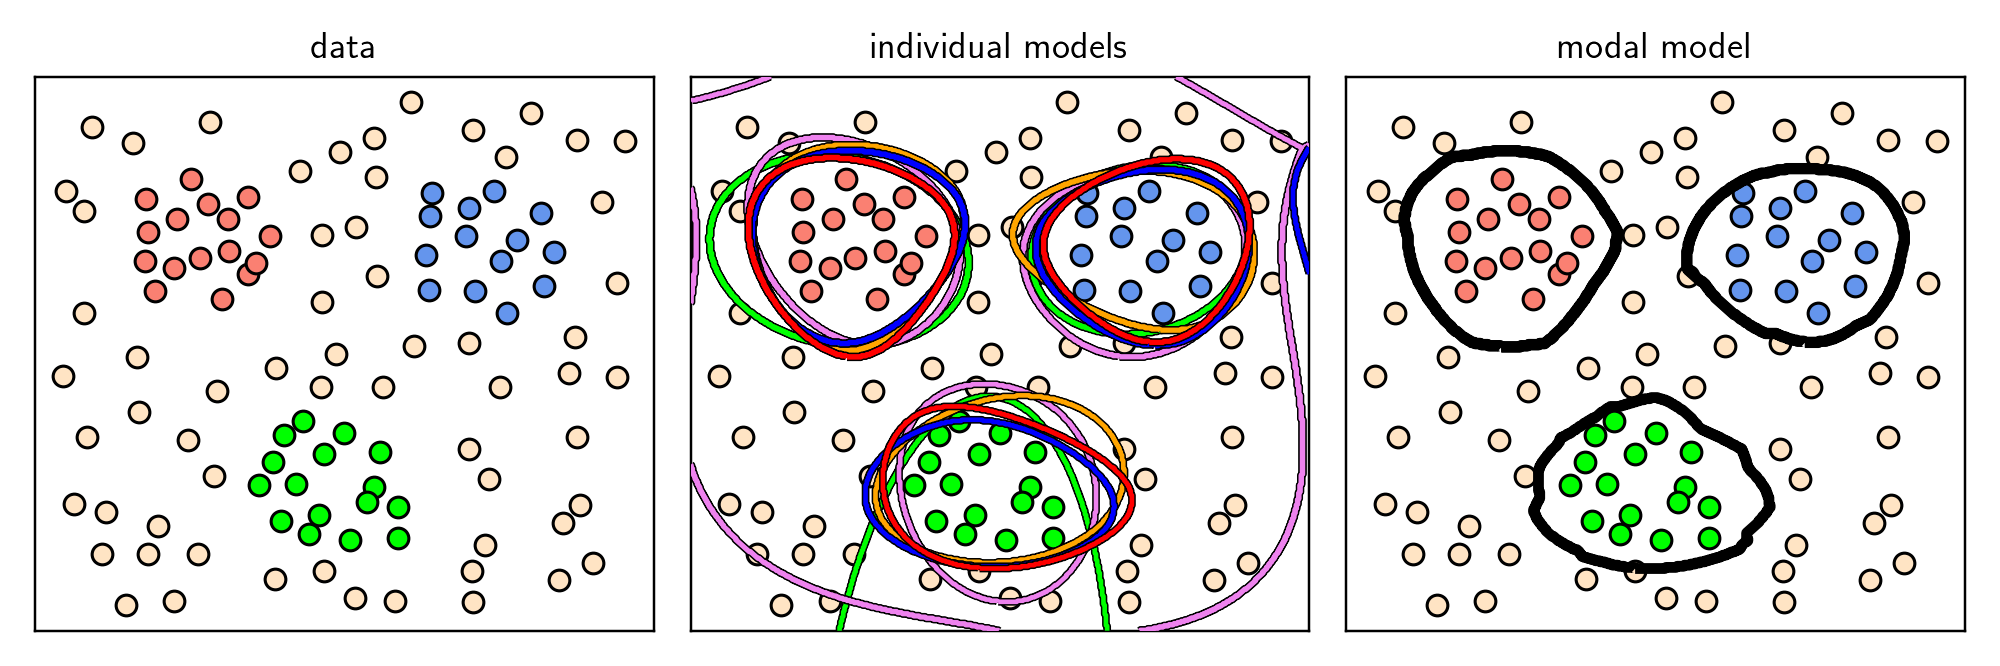

In [20]:
# This code cell will not be shown in the HTML version of this notebook
# load in dataset
csvname = datapath + '3eggs_multiclass.csv'

data = np.loadtxt(csvname,delimiter = ',')
x = data[:-1,:]
y = data[-1:,:] 

# run bagg
degree = 5
num_baggs = 5
train_portion = 0.66
runs6 = []
for j in range(num_baggs):
    # initialize with input/output data
    mylib6 = nonlib.reg_lib.super_setup.Setup(x,y)

    # perform preprocessing step(s) - especially input normalization
    mylib6.preprocessing_steps(name = 'standard')
    
    # pluck out indices of current training / validation sets
    mylib6.make_train_val_split(train_portion = train_portion)
    
    # loop over models to try
    for d in range(1,degree+1):
        # choose cost
        mylib6.choose_cost(name = 'multiclass_softmax')

        # choose dimensions of fully connected multilayer perceptron layers
        mylib6.choose_features(name = 'polys',degree = d,num_classifiers = 4)
        
        # fit an optimization
        mylib6.fit(algo = 'newtons_method',max_its = 5,verbose = False,lam = 10**(-6))
        
    # keep only the best degree, based on lowest validation cost
    val_costs = [np.min(mylib6.valid_count_histories[i]) for i in range(degree)]
    min_ind = np.argmin(val_costs)
    min_val = val_costs[min_ind]
    
    # get minor of minor
    smallest_ind = np.argmin(mylib6.valid_count_histories[min_ind])
    mylib6.train_cost_histories = mylib6.train_cost_histories[min_ind][smallest_ind]
    mylib6.valid_cost_histories = mylib6.valid_cost_histories[min_ind][smallest_ind]
    mylib6.train_count_histories = mylib6.train_count_histories[min_ind][smallest_ind]
    mylib6.valid_count_histories = mylib6.valid_count_histories[min_ind][smallest_ind]
    mylib6.weight_histories = mylib6.weight_histories[min_ind][smallest_ind]
    mylib6.choose_features(name = 'polys',degree = min_ind + 1)
        
    # store 
    runs6.append(copy.deepcopy(mylib6))
    
# draw pics
demo4 = nonlib.multiclass_bagging_visualizers.Visualizer(csvname)
demo4.show_baggs(runs6)

## 11.5.3  How many models should we ensemble in practice?

Note that in these Examples the number of cross-validated models ensembled is somewhat arbitrary.  Like other important parameters involved withi cross-validation - e.g., the portion of a dataset to reserve for validation - there is no magic number (of cross-validated models) used generally in practice for ensembling regressors or classifiers.  If - on the one hand - a random validation portion of a dataset generally represents it well there is less need to ensemble as we can trust each cross-validated model more.  The less we could trust in the faithfulness of a random validation portion to represents a phenomenon at large, the more cross-validated models we might want to ensemble to help avoid bad splits of the data and the resulting poor cross-validated models trained on them.  Since this is generally impossible to determine in practice often practical considerations - e.g., computation power - determine if ensembling is used and if so how many cross-validated models are employed.  